In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

import os
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
%cd 'gdrive/My Drive/facial-keypoints-detection'
os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
%cd cupoy_cv_part4 # 可以自己改路徑

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/facial-keypoints-detection
[Errno 2] No such file or directory: 'cupoy_cv_part4 # 可以自己改路徑'
/content/gdrive/My Drive/facial-keypoints-detection


In [0]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [4]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.


In [0]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()
    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [7]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [8]:
# 印出網路結構
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)        

In [0]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [10]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')




Train on 1712 samples, validate on 428 samples
Epoch 1/150





1712/1712 [==============================] - 16s 9ms/step - loss: 0.0060 - val_loss: 0.0022

Epoch 00001: val_loss improved from inf to 0.00225, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 0s 233us/step - loss: 0.0017 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00225 to 0.00191, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 0s 231us/step - loss: 0.0014 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00191 to 0.00189, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 0s 238us/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00189
Epoch 5/150
1712/1712 [==============================] - 0s 223us/step - loss: 0.0011 - val_loss: 0.0019

Epoch 00005: val_loss did not improve from 0.00189
Epoch 6/150
1712/1712 [==============================]

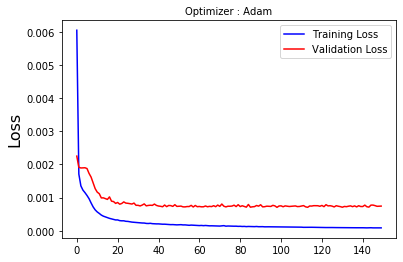

In [11]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [17]:
%ls

best_weights.h5  D43-44             SampleSubmission.csv  training/
cupoy_cv_part4/  IdLookupTable.csv  test/                 training.csv
D42.ipynb        model.h5           test.csv              weights.h5


In [0]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [0]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

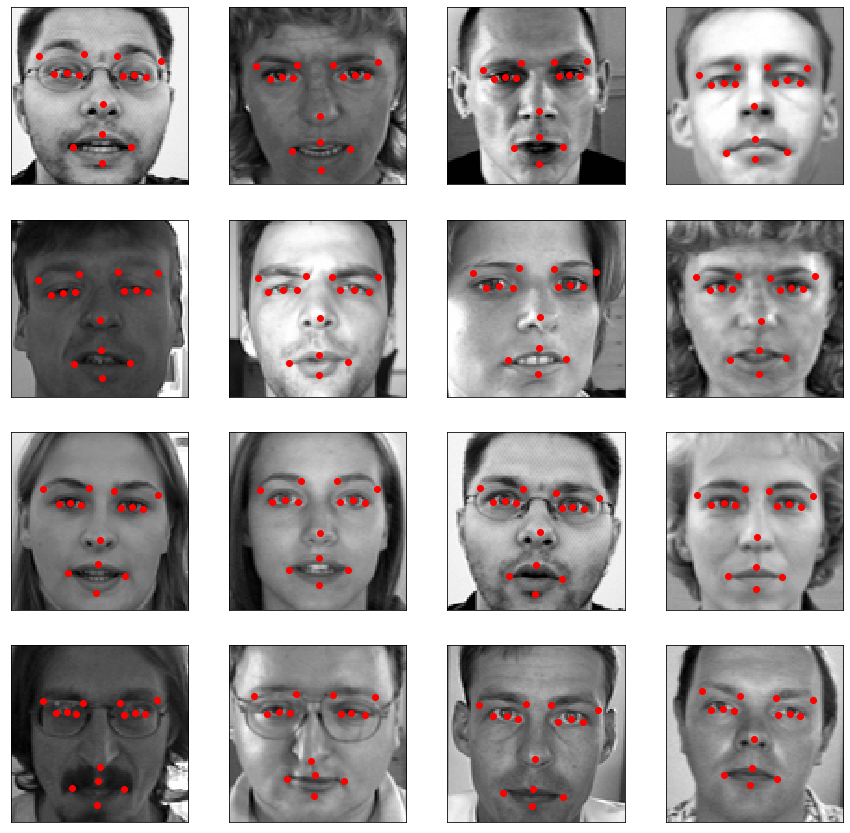

In [20]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

In [0]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [0]:
# 實現圖片以及關機點 label 做左右翻轉的函數
def augment_data(img, points):
    rows, cols = img.shape
    new_img = np.copy(img)
    
    # 翻轉圖片
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = temp
            
    # 翻轉關鍵點 label
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
    
    # 調整對稱的 label
    new_points_temp = np.copy(new_points)
    new_points[0:2] = new_points_temp[2:4]
    new_points[2:4] = new_points_temp[0:2]
    new_points[4:6] = new_points_temp[8:10]
    new_points[6:8] = new_points_temp[10:12]
    new_points[8:10] = new_points_temp[4:6]
    new_points[10:12] = new_points_temp[6:8]
    new_points[12:14] = new_points_temp[16:18]
    new_points[14:16] = new_points_temp[18:20]
    new_points[16:18] = new_points_temp[12:14]
    new_points[18:20] = new_points_temp[14:16]
    new_points[22:24] = new_points_temp[24:26]
    new_points[24:26] = new_points_temp[22:24]
        
    return new_img, new_points

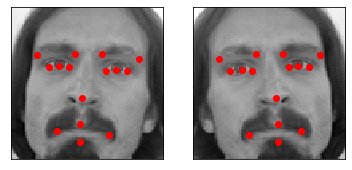

In [23]:
flip_img, flip_points = augment_data(imgs_train[0], points_train[0])

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_keypoints(imgs_train[0], points_train[0]) # 原來的圖片
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_keypoints(flip_img, flip_points) # 翻轉後的圖片

In [24]:
# 創建 list
aug_imgs_train = []
aug_points_train = []

# 對所有原始資料做 augmentation
for i in range(imgs_train.shape[0]):
    # 做左右翻轉
    aug_img, aug_point = augment_data(imgs_train[i], points_train[i])
    
    # append 原始資料
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
    
    # append 做過 augmentation 後的資料
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

(4280, 96, 96)
(4280, 30)


In [25]:
# model checkpoint 
checkpoint_aug = ModelCheckpoint('best_weights_augment.h5', verbose=1, save_best_only=True)
# training the model
hist_model_aug = model_with_augment.fit(aug_imgs_train.reshape(aug_imgs_train.shape[0], 96, 96, 1), aug_points_train, 
                           validation_split=0.2, batch_size=64, callbacks=[checkpoint_aug, hist],
                           shuffle=True, epochs=150, verbose=1)

Train on 3424 samples, validate on 856 samples
Epoch 1/150
3424/3424 [==============================] - 2s 453us/step - loss: 0.0064 - val_loss: 0.0020

Epoch 00001: val_loss improved from inf to 0.00202, saving model to best_weights_augment.h5
Epoch 2/150
3424/3424 [==============================] - 1s 228us/step - loss: 0.0015 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00202 to 0.00190, saving model to best_weights_augment.h5
Epoch 3/150
3424/3424 [==============================] - 1s 225us/step - loss: 0.0012 - val_loss: 0.0018

Epoch 00003: val_loss improved from 0.00190 to 0.00184, saving model to best_weights_augment.h5
Epoch 4/150
3424/3424 [==============================] - 1s 242us/step - loss: 0.0011 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00184
Epoch 5/150
3424/3424 [==============================] - 1s 234us/step - loss: 9.6076e-04 - val_loss: 0.0017

Epoch 00005: val_loss improved from 0.00184 to 0.00167, saving model to best_weights

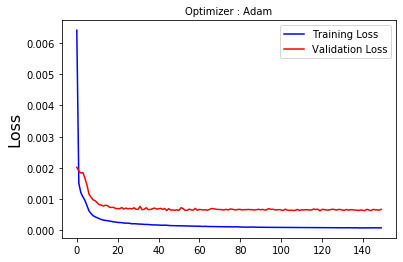

In [26]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model_aug.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model_aug.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [0]:
model = get_model()
model.load_weights("best_weights.h5") # 載入之前 train 好的權重

In [0]:
sample_img = imgs_train[0] # 選一張圖片做人臉濾鏡的樣本
sample_point = points_train[0]
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')
        plt.text((points[i] + 0.5)*96, (points[i+1]+0.5-0.05)*96, str(int(i/2))) # 把關鍵點 index 畫出來

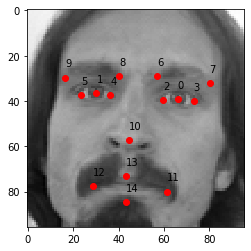

In [29]:
plot_keypoints(sample_img, sample_point)

In [53]:
sample_img

array([[0.93333334, 0.9254902 , 0.92941177, ..., 0.98039216, 0.98039216,
        0.98039216],
       [0.92156863, 0.93333334, 0.9254902 , ..., 0.9764706 , 0.98039216,
        0.9843137 ],
       [0.92941177, 0.9254902 , 0.92941177, ..., 0.9843137 , 0.9843137 ,
        0.98039216],
       ...,
       [0.7294118 , 0.7176471 , 0.70980394, ..., 0.20392157, 0.22352941,
        0.23529412],
       [0.7411765 , 0.7372549 , 0.8117647 , ..., 0.23921569, 0.27058825,
        0.30588236],
       [0.7490196 , 0.72156864, 0.72156864, ..., 0.27450982, 0.29411766,
        0.3529412 ]], dtype=float32)

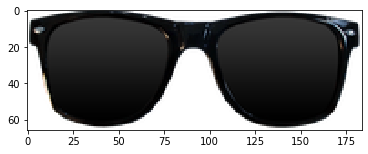

In [120]:
import cv2
sunglasses = cv2.imread('sunglasses.png', cv2.IMREAD_UNCHANGED) # cv2.IMREAD_UNCHANGED 表示要讀取圖像透明度的 channel
plt.imshow(sunglasses)

In [0]:
landmarks = model.predict(sample_img.reshape(-1, 96, 96, 1)) # 預測人臉關鍵點
landmarks = (landmarks + 0.5) * 96 # 將預測的人臉關鍵點的數值範圍由 -0.5 ~ 0.5 轉回 0 ~ 96
key_pts = landmarks.reshape(-1, 2)

face_img = cv2.cvtColor((sample_img*255).astype(np.uint8), cv2.COLOR_GRAY2BGR) # 將灰階圖像轉為 BGR

# 以下示範如何用檢測到的關鍵點去定義要增加太陽眼鏡濾鏡的坐標，
# 其中使用的 key_pts index 就是由 plot_keypoints 所畫出來的 index 觀察而來
sunglass_top_x = int(key_pts[9, 0]) # 在這裡選右眉毛的最外側 (也就是第 9 index) 做太陽眼鏡的最左邊
sunglass_w = int(abs(key_pts[9, 0] - key_pts[7, 0])) # 在這裡選右眉毛最外側到左眉毛最外側 (也就是第 7、9 index) 做為太陽眼鏡的寬
sunglass_top_y = int((key_pts[9, 1] + key_pts[5, 1]) / 2) # y 和 h 也是類似的道理了
sunglass_h = int(abs(key_pts[8, 1] - key_pts[10, 1]) / 2)

new_sunglasses =  cv2.resize(sunglasses, (sunglass_w, sunglass_h), interpolation = cv2.INTER_CUBIC)

# roi 為要覆蓋太陽眼鏡的 BGR 人臉範圍
roi = face_img[sunglass_top_y:sunglass_top_y+sunglass_h, sunglass_top_x:sunglass_top_x+sunglass_w]

# 找出非透明的 pixel
ind = np.argwhere(new_sunglasses[:,:,3] > 0)

# 把 roi 中每個 channel 非透明的地方替換為太陽眼鏡的 pixel
for i in range(3):
    roi[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]

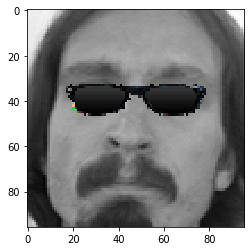

In [35]:
plt.imshow(face_img)

In [43]:
sample_img.shape

(96, 96)

In [0]:
from PIL import Image
import cv2

In [0]:
im = Image.open( "face.jpg" )

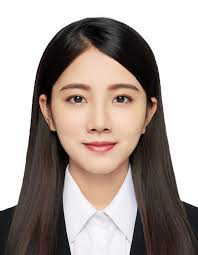

In [5]:
im

In [48]:
im.size

(198, 255)

In [0]:
nim = im.crop( (50, 50, 148, 168) )

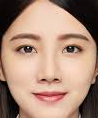

In [104]:
nim

In [0]:
nim2 = nim.resize( (96,96), Image.BILINEAR )

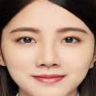

In [106]:
nim2

In [0]:
nim3 = np.array(nim2)

In [55]:
nim3.shape

(96, 96, 3)

In [0]:
nim4 = cv2.cvtColor(nim3, cv2.IMREAD_GRAYSCALE)

In [0]:
nim5 = nim4[...,0]

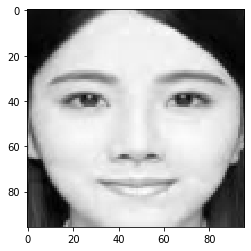

In [110]:
plt.imshow(nim5, cmap='gray')

In [111]:
nim5.max()

255

In [118]:
imgs_train[7].max()

1.0

In [0]:
nim6 = np.vstack(nim5)/255

In [113]:
nim6.max()

1.0

In [0]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [41]:
model = get_model()
model.load_weights("best_weights.h5") # 載入之前 train 好的權重






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








In [0]:
landmarks_1 = model.predict(nim6.reshape(-1, 96, 96, 1)) # 預測人臉關鍵點

In [115]:
landmarks_1

array([[ 0.20693272, -0.08086153, -0.2145485 , -0.07430063,  0.12218463,
        -0.07212854,  0.30035233, -0.07205661, -0.12346132, -0.06679291,
        -0.2991361 , -0.059336  ,  0.10412793, -0.1651997 ,  0.3495822 ,
        -0.1769085 , -0.10242026, -0.16712976, -0.36783278, -0.16166401,
         0.01204246,  0.13283631,  0.1872471 ,  0.29722494, -0.17916197,
         0.31344384,  0.01083799,  0.2932366 ,  0.01218372,  0.36367685]],
      dtype=float32)

In [0]:
# = (landmarks_1 + 0.5) * 96 # 將預測的人臉關鍵點的數值範圍由 -0.5 ~ 0.5 轉回 0 ~ 96
key_pts = landmarks_1.reshape(-1, 2)

In [78]:
landmarks_1[0]

array([ 0.14107253, -0.10721244, -0.15788418, -0.13594525,  0.08197122,
       -0.10168507,  0.20373623, -0.09819878, -0.08550372, -0.11577559,
       -0.23633492, -0.12956181,  0.07763959, -0.14448768,  0.23241219,
       -0.15295073, -0.04955732, -0.16963482, -0.28252047, -0.18420632,
        0.05957994,  0.06500448,  0.08482902,  0.21699283, -0.12382292,
        0.2168436 ,  0.00615656,  0.23275802,  0.00812481,  0.22893065],
      dtype=float32)

In [0]:
sample_img = nim6 # 選一張圖片做人臉濾鏡的樣本
sample_point = landmarks_1[0]
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')
        plt.text((points[i] + 0.5)*96, (points[i+1]+0.5-0.05)*96, str(int(i/2))) # 把關鍵點 index 畫出來

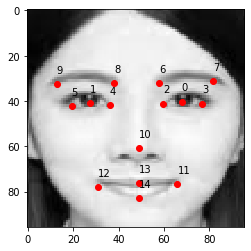

In [117]:
plot_keypoints(sample_img, sample_point)

In [0]:
imgs_train, points_train = load_data(dirname = 'training.csv')

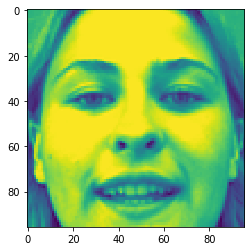

In [83]:
plt.imshow(imgs_train[7])#imgs_train[0].max()

In [0]:
landmarks = landmarks_1[0] # 預測人臉關鍵點
landmarks = (landmarks + 0.5) * 96 # 將預測的人臉關鍵點的數值範圍由 -0.5 ~ 0.5 轉回 0 ~ 96
key_pts = landmarks.reshape(-1, 2)

face_img = cv2.cvtColor((nim6*255).astype(np.uint8), cv2.COLOR_GRAY2BGR) # 將灰階圖像轉為 BGR

# 以下示範如何用檢測到的關鍵點去定義要增加太陽眼鏡濾鏡的坐標，
# 其中使用的 key_pts index 就是由 plot_keypoints 所畫出來的 index 觀察而來
sunglass_top_x = int(key_pts[9, 0]) # 在這裡選右眉毛的最外側 (也就是第 9 index) 做太陽眼鏡的最左邊
sunglass_w = int(abs(key_pts[9, 0] - key_pts[7, 0])) # 在這裡選右眉毛最外側到左眉毛最外側 (也就是第 7、9 index) 做為太陽眼鏡的寬
sunglass_top_y = int((key_pts[9, 1] + key_pts[5, 1]) / 2) # y 和 h 也是類似的道理了
sunglass_h = int(abs(key_pts[8, 1] - key_pts[10, 1]) / 2)

new_sunglasses =  cv2.resize(sunglasses, (sunglass_w, sunglass_h), interpolation = cv2.INTER_CUBIC)

# roi 為要覆蓋太陽眼鏡的 BGR 人臉範圍
roi = face_img[sunglass_top_y:sunglass_top_y+sunglass_h, sunglass_top_x:sunglass_top_x+sunglass_w]

# 找出非透明的 pixel
ind = np.argwhere(new_sunglasses[:,:,3] > 0)

# 把 roi 中每個 channel 非透明的地方替換為太陽眼鏡的 pixel
for i in range(3):
    roi[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]

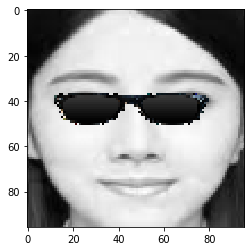

In [122]:
plt.imshow(face_img)

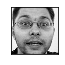

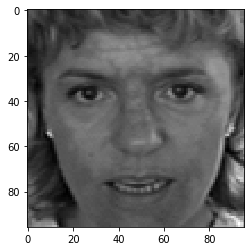

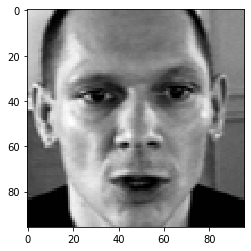

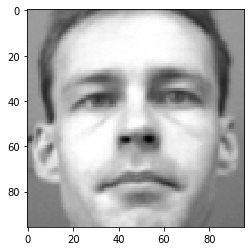

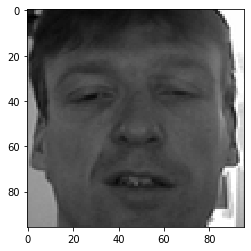

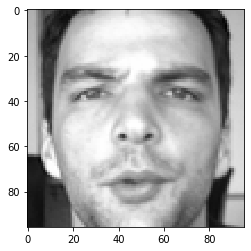

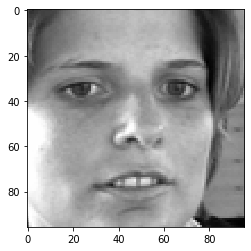

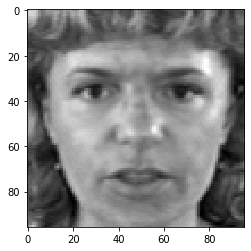

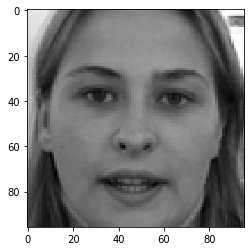

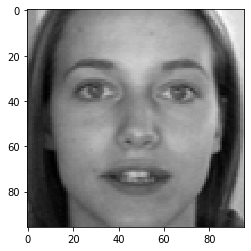

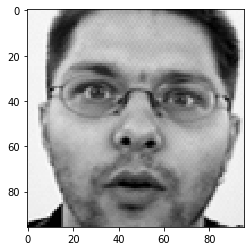

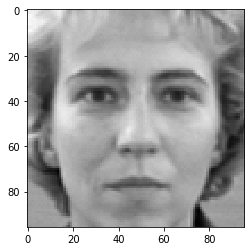

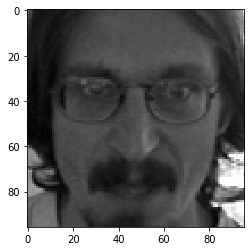

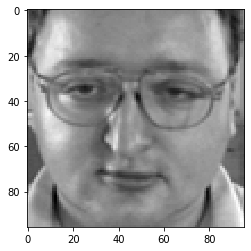

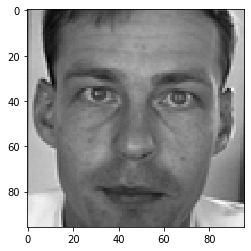

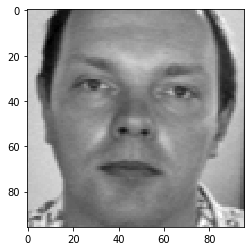

In [14]:
fig = plt.figure()
ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
for i in range(16):
    plt.imshow(imgs_test[i], cmap='gray')
    plt.show()